In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline,FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, mean_squared_error, r2_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

data = pd.read_csv('ratings_clean.csv')

In [2]:
data.head()
data = data.drop(data.index[12958])
data[['year']] = data[['year']].apply(pd.to_numeric)

In [3]:
# correlation 
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,metascore,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,votes_5,votes_4,votes_3,votes_2,votes_1,allgenders_18age_avg_vote,allgenders_30age_avg_vote,allgenders_45age_avg_vote,males_allages_avg_vote,males_18age_avg_vote,males_30age_avg_vote,males_45age_avg_vote,females_allages_avg_vote,females_18age_avg_vote,females_30age_avg_vote,females_45age_avg_vote,Drama,History,Sci-Fi,Music,Musical,Comedy,Romance,Crime,War,Western,Horror,Adventure,Family,Fantasy,Mystery,Thriller,Biography,Animation,Action,Film-Noir,Sport
year,1.000000,-0.184218,-0.267356,-0.029548,-0.254643,-0.201050,-0.056979,-0.053484,-0.041972,-0.004929,0.032559,0.043464,0.045677,0.044872,0.041064,0.033553,-0.239177,-0.269832,-0.297223,-0.269902,-0.236960,-0.270044,-0.297975,-0.254992,-0.219531,-0.249766,-0.261287,0.075932,0.012446,-0.028734,-0.069122,-0.119451,-0.035310,-0.053248,-0.038081,-0.048993,-0.108186,0.012951,-0.039308,-0.059710,-0.020452,0.016827,0.034234,0.047307,0.018872,0.014834,-0.144721,-0.023802
metascore,-0.184218,1.000000,0.692238,0.194167,0.646379,0.616770,0.174051,0.217833,0.254563,0.199447,0.055920,-0.057209,-0.114941,-0.135107,-0.132410,-0.041949,0.674970,0.692181,0.673623,0.700930,0.684594,0.695917,0.678831,0.628479,0.545204,0.627722,0.577461,0.276265,0.068442,-0.045475,0.030500,0.028301,-0.119961,-0.005498,-0.017459,0.057958,0.041349,-0.124811,-0.030274,-0.028321,-0.051549,-0.029548,-0.077741,0.084543,0.066184,-0.156396,0.065426,-0.025780
weighted_average_vote,-0.267356,0.692238,1.000000,0.350695,0.973778,0.922052,0.289876,0.342934,0.406406,0.368057,0.212842,0.067618,-0.023442,-0.073671,-0.099832,-0.035383,0.959169,0.991275,0.966319,0.992376,0.943579,0.984679,0.963466,0.953370,0.843163,0.932711,0.873480,0.248722,0.094176,-0.043381,0.025864,0.015055,-0.114901,0.012361,0.036912,0.082083,0.039763,-0.200956,0.014653,-0.031270,-0.044601,-0.041977,-0.094404,0.137943,0.079066,-0.069044,0.056338,0.016058
total_votes,-0.029548,0.194167,0.350695,1.000000,0.331762,0.297199,0.861012,0.917330,0.955956,0.894911,0.749343,0.647758,0.591844,0.567466,0.552054,0.589829,0.333414,0.347075,0.340081,0.354660,0.330414,0.349867,0.343494,0.325958,0.298778,0.315601,0.301970,-0.130452,-0.007431,0.166535,-0.040030,-0.022484,-0.057882,-0.070057,0.025543,-0.004663,-0.002161,-0.023256,0.225531,0.010939,0.073252,0.024909,0.029374,0.011298,0.056896,0.201573,0.000090,-0.005947
mean_vote,-0.254643,0.646379,0.973778,0.331762,1.000000,0.944884,0.279591,0.330119,0.391770,0.349576,0.187920,0.038049,-0.054104,-0.103439,-0.127451,-0.053857,0.933423,0.960566,0.936492,0.956718,0.911567,0.948457,0.929120,0.942979,0.839144,0.923322,0.863485,0.253852,0.093306,-0.058263,0.041180,0.028304,-0.103509,0.023933,0.021314,0.081935,0.034958,-0.224376,0.012688,-0.016133,-0.043167,-0.058264,-0.111610,0.138438,0.081835,-0.079197,0.052334,0.021208
median_vote,-0.201050,0.616770,0.922052,0.297199,0.944884,1.000000,0.259404,0.301037,0.348909,0.305669,0.162603,0.029822,-0.053314,-0.100252,-0.126287,-0.058876,0.885026,0.910211,0.879755,0.905897,0.865689,0.899023,0.873011,0.887265,0.788542,0.870770,0.805382,0.251794,0.084908,-0.053035,0.032623,0.025578,-0.106280,0.021386,0.016115,0.075178,0.033794,-0.200157,-0.001761,-0.036339,-0.039640,-0.053570,-0.101915,0.121779,0.063656,-0.081950,0.044389,0.008260
votes_10,-0.056979,0.174051,0.289876,0.861012,0.279591,0.259404,1.000000,0.936734,0.775630,0.575340,0.402076,0.334193,0.311126,0.322046,0.347130,0.500275,0.275847,0.287183,0.277285,0.290543,0.272161,0.287627,0.278993,0.271495,0.247263,0.265990,0.245758,-0.038214,0.000512,0.084817,-0.016562,-0.006748,-0.054978,-0.040439,0.013936,0.007031,0.006591,-0.031807,0.128455,0.008483,0.037868,0.004057,-0.006798,0.008735,0.037290,0.091831,0.003339,-0.005007
votes_9,-0.053484,0.217833,0.342934,0.917330,0.330119,0.301037,0.936734,1.000000,0.905246,0.672633,0.445012,0.346969,0.313322,0.317963,0.339279,0.455784,0.326719,0.340274,0.328996,0.345292,0.324112,0.342001,0.33182

In [4]:
# Set up X and y variables
X = data.drop(['imdb_title_id', 'title','metascore'], axis=1)
y = data[['metascore']]

In [5]:
# Make training and testing sets, giving testing set 20% of data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [6]:
# Make variables for both the categorical and numerical variables in the X table
numeric_features = X.select_dtypes(exclude='object').columns
# only need this if we have categorical variable
categorical_features = X.select_dtypes('object').columns

In [7]:
# Make pipeline for Numeric featurs to be transformed into workable data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

In [8]:
# Only need this if we use categorical data
# Make pipeline for Categorical Features to be transformed into workable data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [9]:
# Make a pipeline combining both numeric and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [10]:
# Make a pipeline that applies the preprocessing of the data, 
# and applies a Lasso regression feature selection on the data.
laspipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor',  Lasso(alpha=.5))])

knnpipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn',  KNeighborsRegressor(n_neighbors=5))])

lrpipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linearregression', LinearRegression(fit_intercept=False))])

dtpipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('decisiontreeregressor', DecisionTreeRegressor())])



In [11]:
# Fit pipeline to train data
laspipe.fit(X_train, y_train)
knnpipe.fit(X_train, y_train)
lrpipe.fit(X_train, y_train)
dtpipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['year', 'weighted_average_vote', 'total_votes', 'mean_vote',
       'median_vote', 'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6',
       'votes_5', 'votes_4', 'votes_3', 'votes_2', 'votes_1',
       'allgenders_18age_avg_vote...
       'Western', 'Horror', 'Adventure', 'Family', 'Fantasy', 'Mystery',
       'Thriller', 'Biography', 'Animation', 'Action', 'Film-Noir', 'Sport'],
      dtype='object')),
                                                 ('cat',
                                                  Pipel

In [12]:
# Find Mean Square errors
# lasso
yhat_las = laspipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, yhat_las)))

# knn
yhat_knn = knnpipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, yhat_knn)))

# linear regression
yhat_lr = lrpipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, yhat_lr)))

# decision trees
yhat_dt = dtpipe.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, yhat_dt)))

12.177259012410774
12.70295993344673
57.01683130272256
15.378636458624115


In [13]:
# Cross Validation score for Mean Absolute Error

# lasso
MAE_las = cross_val_score(laspipe, X_train, y_train, scoring='neg_mean_absolute_error')
print(np.mean(MAE_las)*-1)

# knn
MAE_knn = cross_val_score(knnpipe, X_train, y_train, scoring='neg_mean_absolute_error')
print(np.mean(MAE_knn)*-1)

# linear regression
MAE_lr = cross_val_score(lrpipe, X_train, y_train, scoring='neg_mean_absolute_error')
print(np.mean(MAE_lr)*-1)

# decision trees
MAE_dt = cross_val_score(dtpipe, X_train, y_train, scoring='neg_mean_absolute_error')
print(np.mean(MAE_dt)*-1)

9.954055146050106
10.110086327556242
55.94360681218829
12.220234259501556


In [14]:
# Cross Validation score for Mean Squared Error

# lasso
MSE_las = cross_val_score(laspipe, X_train, y_train, scoring='neg_mean_squared_error')
print(np.mean(MSE_las)*-1)

# knn
MSE_knn = cross_val_score(knnpipe, X_train, y_train, scoring='neg_mean_squared_error')
print(np.mean(MSE_knn)*-1)

# linear regression
MSE_lr = cross_val_score(lrpipe, X_train, y_train, scoring='neg_mean_squared_error')
print(np.mean(MSE_lr)*-1)

# decision trees
MSE_dt = cross_val_score(dtpipe, X_train, y_train, scoring='neg_mean_squared_error')
print(np.mean(MSE_dt)*-1)

154.0117768943061
162.22024677361998
3274.046691663391
240.77650113730147


In [15]:
# Cross Validation score for Root Mean Squared Error

# lasso
RMSE_las = cross_val_score(laspipe, X_train, y_train, scoring='neg_root_mean_squared_error')
print(np.mean(RMSE_las)*-1)

# knn
RMSE_knn = cross_val_score(knnpipe, X_train, y_train, scoring='neg_root_mean_squared_error')
print(np.mean(RMSE_knn)*-1)

# linear regression
RMSE_lr = cross_val_score(lrpipe, X_train, y_train, scoring='neg_root_mean_squared_error')
print(np.mean(RMSE_lr)*-1)

# decision trees
RMSE_dt = cross_val_score(dtpipe, X_train, y_train, scoring='neg_root_mean_squared_error')
print(np.mean(RMSE_dt)*-1)

12.409150667849222
12.735243529891704
57.21908102086684
15.600191607587442


Text(0.5, 1.0, 'Scatterplot between Y_test and Predicted values with Lasso')

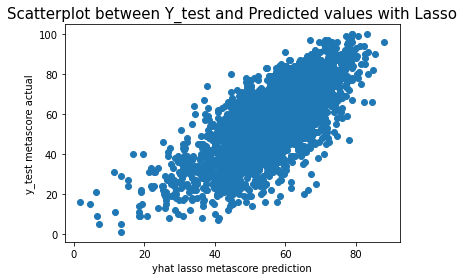

In [16]:
plt.scatter(yhat_las, y_test['metascore'])
plt.xlabel("yhat lasso metascore prediction")
plt.ylabel("y_test metascore actual")
plt.title("Scatterplot between Y_test and Predicted values with Lasso", fontsize=15)

Text(0.5, 1.0, 'Scatterplot between Y_test and Predicted values with K Nearest Neighbors')

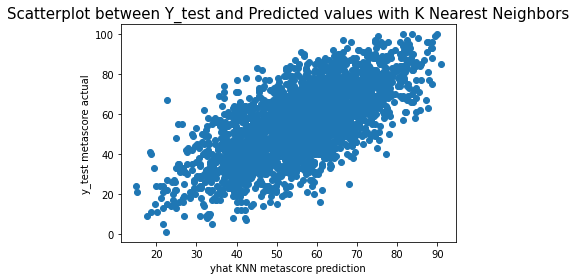

In [17]:
plt.scatter(yhat_knn, y_test['metascore'])
plt.xlabel("yhat KNN metascore prediction")
plt.ylabel("y_test metascore actual")
plt.title("Scatterplot between Y_test and Predicted values with K Nearest Neighbors", fontsize=15)

Text(0.5, 1.0, 'Scatterplot between Y_test and Predicted values with Linear Regression')

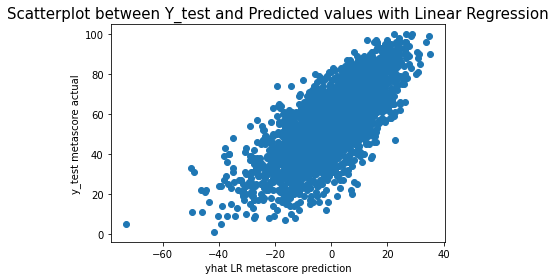

In [18]:
plt.scatter(yhat_lr, y_test['metascore'])
plt.xlabel("yhat LR metascore prediction")
plt.ylabel("y_test metascore actual")
plt.title("Scatterplot between Y_test and Predicted values with Linear Regression", fontsize=15)

Text(0.5, 1.0, 'Scatterplot between Y_test and Predicted values with Decision Tree')

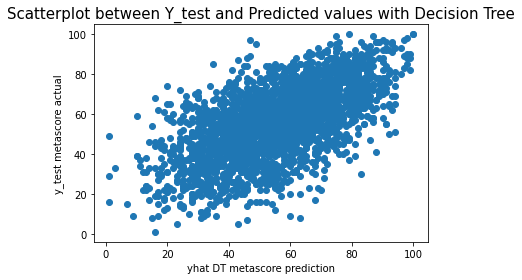

In [19]:
plt.scatter(yhat_dt, y_test['metascore'])
plt.xlabel("yhat DT metascore prediction")
plt.ylabel("y_test metascore actual")
plt.title("Scatterplot between Y_test and Predicted values with Decision Tree", fontsize=15)